In [16]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from PIL import Image
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader
import csv
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_graph(name, object, label_one, std_dev=None, ylabel_loss=True, yl = None):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 5))
    plt.title(name)
    plt.plot(object, label=label_one)
    if std_dev is not None:
        plt.fill_between(range(len(object)), [m - d for m, d in zip(object, std_dev)], [m + d for m, d in zip(object, std_dev)], alpha=0.2)

    plt.xlabel("Epochs")
    if ylabel_loss:
        plt.ylabel("Loss")
    else:
        plt.ylabel("Accuracy")
    if yl is not None:
        plt.ylim(0, yl)
    plt.legend()
    plt.show()

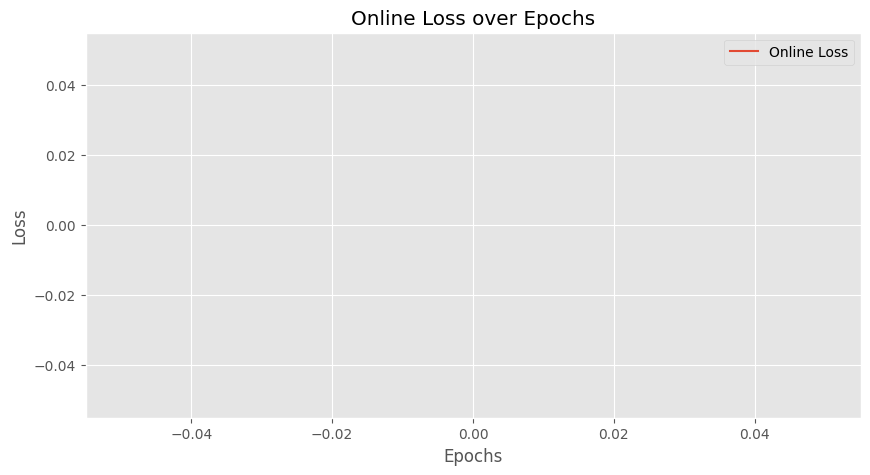

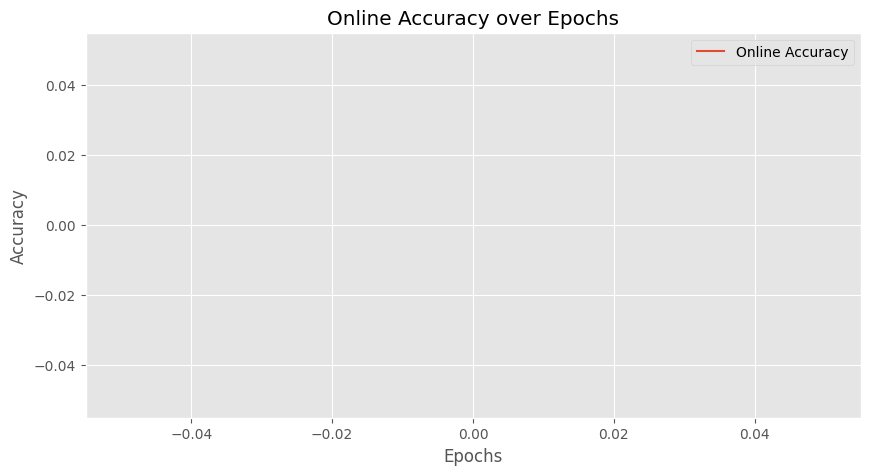

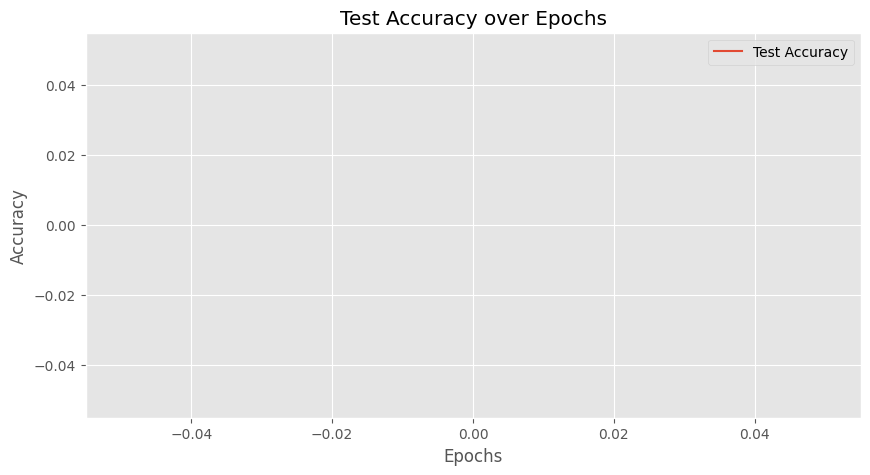

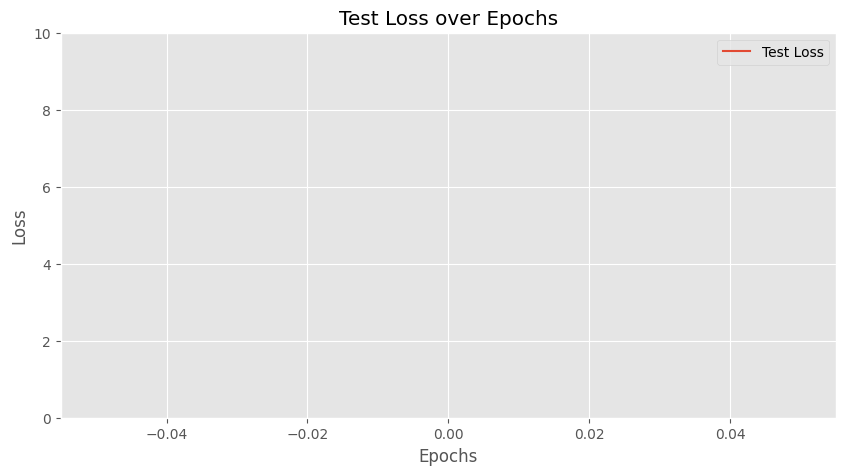

In [54]:
df_path = os.path.join('result_online','cnn_2_0.001_SGD')
df = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))
plot_graph(name ="Online Loss over Epochs", object=df['Train Loss'], label_one='Online Loss', std_dev= std['Train Loss'])
plot_graph(name ="Online Accuracy over Epochs", object=df['Train Accuracy'], label_one='Online Accuracy', std_dev= std['Train Accuracy'], ylabel_loss = False)
plot_graph(name ="Test Accuracy over Epochs", object=df['Val Accuracy'], label_one='Test Accuracy', std_dev= std['Val Accuracy'], ylabel_loss = False)
plot_graph(name ="Test Loss over Epochs", object=df['Val Loss'], label_one='Test Loss', std_dev= std['Val Loss'], yl = 10)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_graph_2(name, object1, label_one, object2, label_two, std_dev1=None, std_dev2=None, ylabel_loss=True, yl = None):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 5))
    #plt.title(name)
    
    plt.plot(object1, label=label_one)
    if std_dev1 is not None:
        plt.fill_between(range(len(object1)), [m - d for m, d in zip(object1, std_dev1)], [m + d for m, d in zip(object1, std_dev1)], alpha=0.2)
    
    plt.plot(object2, label=label_two)
    if std_dev2 is not None:
        plt.fill_between(range(len(object2)), [m - d for m, d in zip(object2, std_dev2)], [m + d for m, d in zip(object2, std_dev2)], alpha=0.2)
    
    plt.xlabel("Epochs")
    if ylabel_loss:
        plt.ylabel("Loss")
    else:
        plt.ylabel("Accuracy")
    if yl is not None:
        plt.ylim(0, yl)
    plt.legend()
    plt.show()

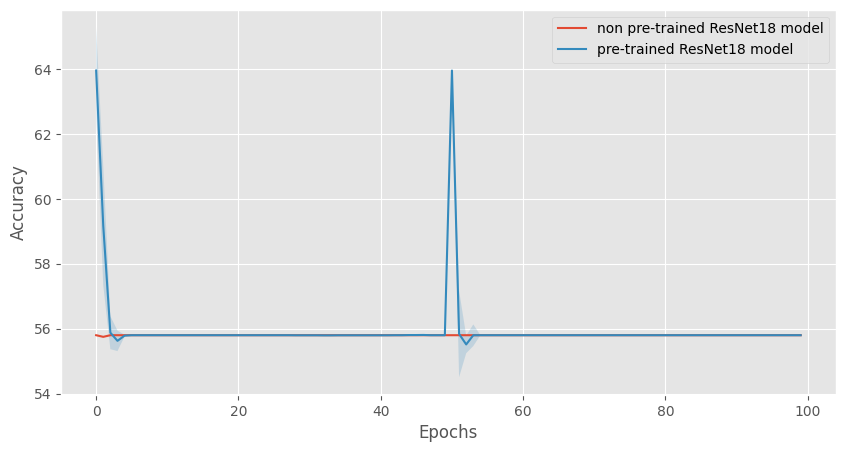

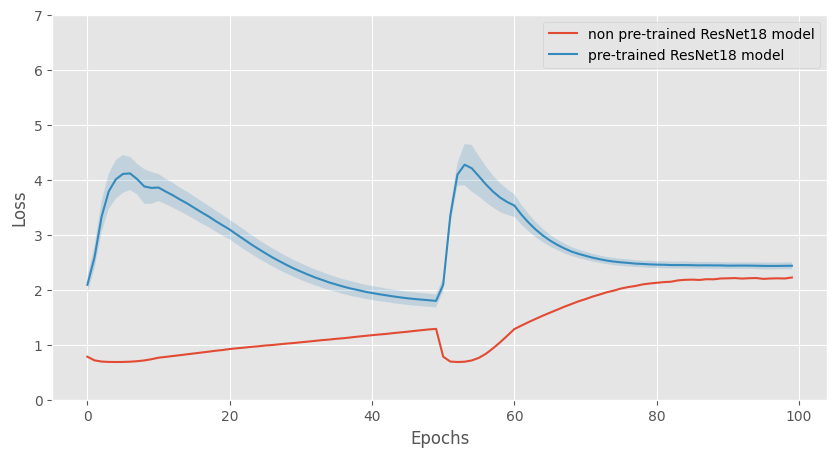

In [49]:
df_path_np = os.path.join('result_online','cnn_50_0.001_SGD')
df = pd.read_csv(os.path.join(df_path_np,'average_loss_and_accuracy'))
std = pd.read_csv(os.path.join(df_path_np,'std_loss_and_accuracy'))
df_path = os.path.join('result_online','cnn_50_0.001_SGD_pt')
df_p = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std_p = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))

# Suppression des lignes pour df
rows_to_delete = [i for i in range(50, len(df), 51)]
df = df.drop(rows_to_delete).reset_index(drop=True)

#Suppression des lignes pour df_p
rows_to_delete_p = [i for i in range(50, len(df_p), 51)]
df_p = df_p.drop(rows_to_delete_p).reset_index(drop=True)

plot_graph_2(name ="Accuracy over Epochs",
            object1=df['Val Accuracy'],
            object2=df_p['Val Accuracy'],
            label_one='non pre-trained ResNet18 model',
            label_two='pre-trained ResNet18 model',
            std_dev1= std['Val Accuracy'],
            std_dev2= std_p['Val Accuracy'],
            ylabel_loss=False
            )
plot_graph_2(name ="Loss over Epochs",
            object1=df['Val Loss'],
            object2=df_p['Val Loss'],
            label_one='non pre-trained ResNet18 model',
            label_two='pre-trained ResNet18 model',
            std_dev1= std['Val Loss'],
            std_dev2= std_p['Val Loss'],
            ylabel_loss=True,
            yl = 7
            )

In [18]:
n_epoch = 50
device = torch.device("cuda")
rd_accuracy = []
correct_predictions = 0
total_samples = 0

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = F.one_hot(torch.tensor(label), num_classes=2).squeeze().to(torch.float32)
        return image, label
    
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    
batch_size = 1024
with open("validation/image_list.txt", 'r') as f:
    lines = f.readlines()#[next(f) for _ in range(1000)] 

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    if line[1] == "0"  or line[1] == "1":
        
        image_paths.append("validation/" + line[0])
    
        labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform_val = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.flatten(x))
])
df_val = CustomDataset(image_paths, labels, transform=transform_val)
valloader = DataLoader(df_val, batch_size=batch_size, shuffle=True)


import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F

n_epoch = 50
device = torch.device("cuda")
rd_accuracy_all = []

def random_model(seed):
    torch.manual_seed(seed)
    rd_accuracy = []
    correct_predictions = 0
    total_samples = 0
    for epoch in range(n_epoch):
        rd_epoch_accuracy = 0
        total_samples = 0
        correct_predictions = 0
        with torch.no_grad():
            for images, labels in valloader:
                labels = labels.to(device)
                labels_ = torch.argmax(labels, dim=1)
                predicted = torch.randint(low=0, high=2, size=(labels_.shape[0],))
                predicted = predicted.to(device)
                correct_predictions += (predicted == labels_).sum().item()
                total_samples += labels_.shape[0]
        rd_epoch_accuracy = (correct_predictions / total_samples) * 100
        rd_accuracy.append(rd_epoch_accuracy)
    return rd_accuracy

for seed in range(5):
    rd_accuracy_all.append(random_model(seed))

# Calculer la moyenne et la variance à chaque epoch
accuracy_mean = np.mean(rd_accuracy_all, axis=0)
accuracy_variance = np.var(rd_accuracy_all, axis=0)

# Afficher les résultats
for epoch in range(n_epoch):
    print(f"Epoch [{epoch+1}/{n_epoch}], Average Random Accuracy: {accuracy_mean[epoch]:.2f}%, Variance: {accuracy_variance[epoch]:.2f}")


Epoch [1/50], Average Random Accuracy: 50.09%, Variance: 0.20
Epoch [2/50], Average Random Accuracy: 49.93%, Variance: 0.14
Epoch [3/50], Average Random Accuracy: 49.77%, Variance: 0.09
Epoch [4/50], Average Random Accuracy: 49.77%, Variance: 0.21
Epoch [5/50], Average Random Accuracy: 50.05%, Variance: 0.36
Epoch [6/50], Average Random Accuracy: 50.20%, Variance: 0.44
Epoch [7/50], Average Random Accuracy: 49.70%, Variance: 0.21
Epoch [8/50], Average Random Accuracy: 50.57%, Variance: 0.83
Epoch [9/50], Average Random Accuracy: 49.69%, Variance: 0.36
Epoch [10/50], Average Random Accuracy: 49.94%, Variance: 0.46
Epoch [11/50], Average Random Accuracy: 50.47%, Variance: 0.11
Epoch [12/50], Average Random Accuracy: 50.25%, Variance: 0.07
Epoch [13/50], Average Random Accuracy: 50.18%, Variance: 0.62
Epoch [14/50], Average Random Accuracy: 50.14%, Variance: 0.17
Epoch [15/50], Average Random Accuracy: 50.19%, Variance: 0.28
Epoch [16/50], Average Random Accuracy: 50.29%, Variance: 0.15
E

In [19]:
def plot_graph_3(name, object1, label_one, object2, label_two, object3, label_three, std_dev3 = None, std_dev1=None, std_dev2=None, ylabel_loss=True):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 5))
    #plt.title(name)
    
    plt.plot(object1, label=label_one)
    if std_dev1 is not None:
        plt.fill_between(range(len(object1)), [m - d for m, d in zip(object1, std_dev1)], [m + d for m, d in zip(object1, std_dev1)], alpha=0.2)

    plt.plot(object2, label=label_two, linestyle='dashed')
    if std_dev2 is not None:
        plt.fill_between(range(len(object2)), [m - d for m, d in zip(object2, std_dev2)], [m + d for m, d in zip(object2, std_dev2)], alpha=0.2)
    
    plt.plot(object3, label=label_three)
    if std_dev3 is not None:
        plt.fill_between(range(len(object3)), [m - d for m, d in zip(object3, std_dev3)], [m + d for m, d in zip(object3, std_dev3)], alpha=0.2)
    
    plt.xlabel("Epochs")
    if ylabel_loss:
        plt.ylabel("Loss")
    else:
        plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

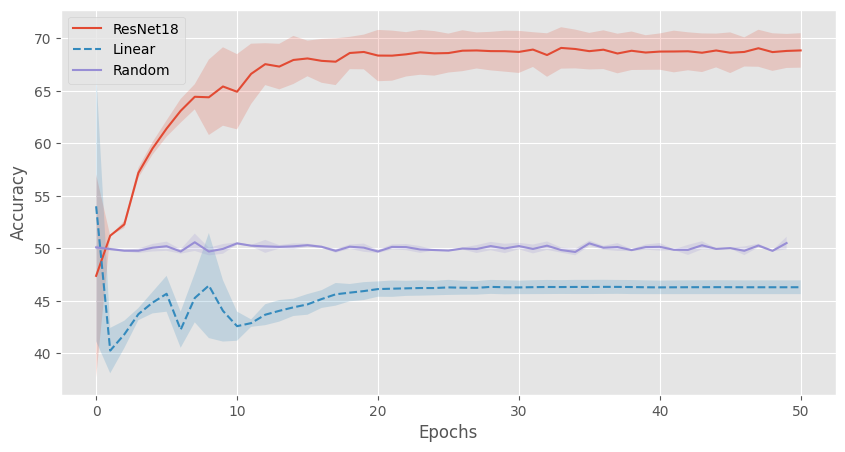

In [20]:
df_path = os.path.join('result','cnn_50_0.001_SGD')
df = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))

df_path = os.path.join('result','linear_50_0.001_SGD')
df_linear = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std_linear = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))


plot_graph_3(name = 'osef',
            object1 = df['Val Accuracy'] , 
            label_one = 'ResNet18', 
            object2 = df_linear['Val Accuracy'], 
            label_two = 'Linear', 
            object3 = accuracy_mean, 
            label_three = 'Random',
            std_dev1=std['Val Accuracy'], 
            std_dev2=std_linear['Val Accuracy'], 
            std_dev3 = accuracy_variance,
            ylabel_loss=False)

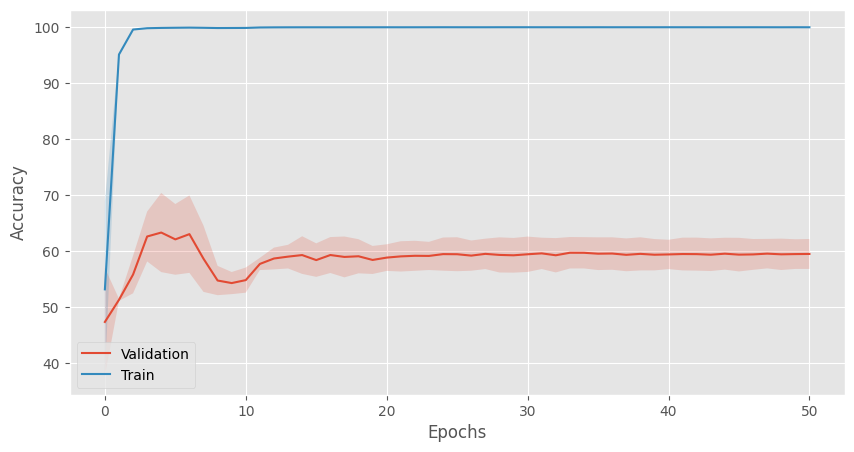

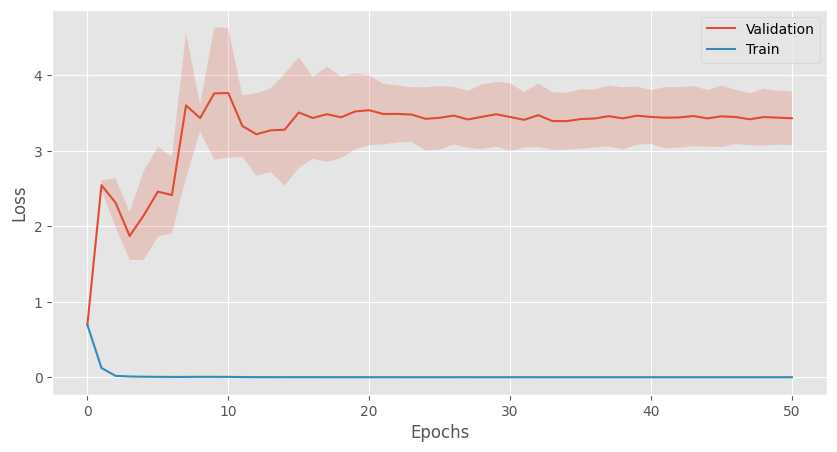

'plot_graph(name ="Loss over Epochs",\n            object1=df_linear[\'Val Accuracy\'],\n            object2=rd_accuracy,\n            label_one=\'Linear\',\n            label_two=\'Random\',\n            std_dev1= std_linear[\'Val Accuracy\'],\n            ylabel_loss=False\n            )'

In [7]:
plot_graph_2(name ="Accuracy over Epochs",
            object1=df['Val Accuracy'],
            object2=df['Train Accuracy'],
            label_one='Validation',
            label_two='Train',
            std_dev1= std['Val Accuracy'],
            std_dev2= std['Train Accuracy'],
            ylabel_loss=False
            )
plot_graph_2(name ="Loss over Epochs",
            object1=df['Val Loss'],
            object2=df['Train Loss'],
            label_one='Validation',
            label_two='Train',
            std_dev1= std['Val Loss'],
            std_dev2= std['Train Loss'],
            ylabel_loss=True
            )

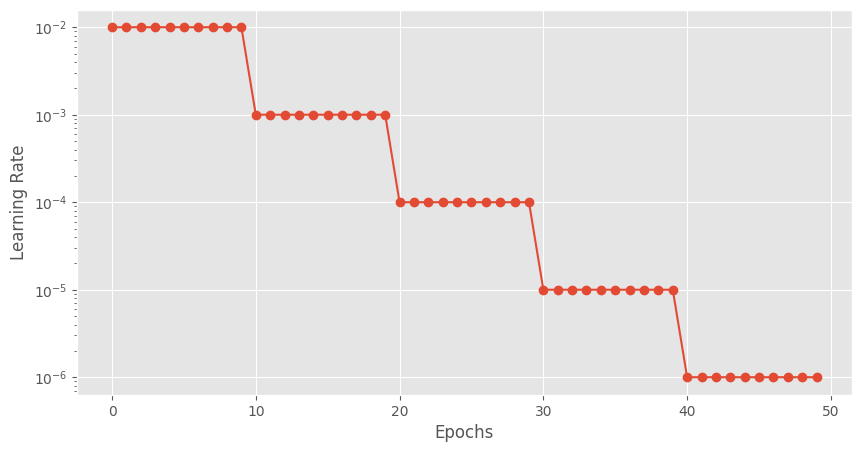

In [10]:
lr = []
x = 0.01
for i in range (5):
    for i in range (10):
        lr.append(x)
    x *= 0.1

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.semilogy(range(len(lr)), lr, marker='o') 
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.show()

/home/lorma/RL_online_transfer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/lorma/RL_online_transfer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


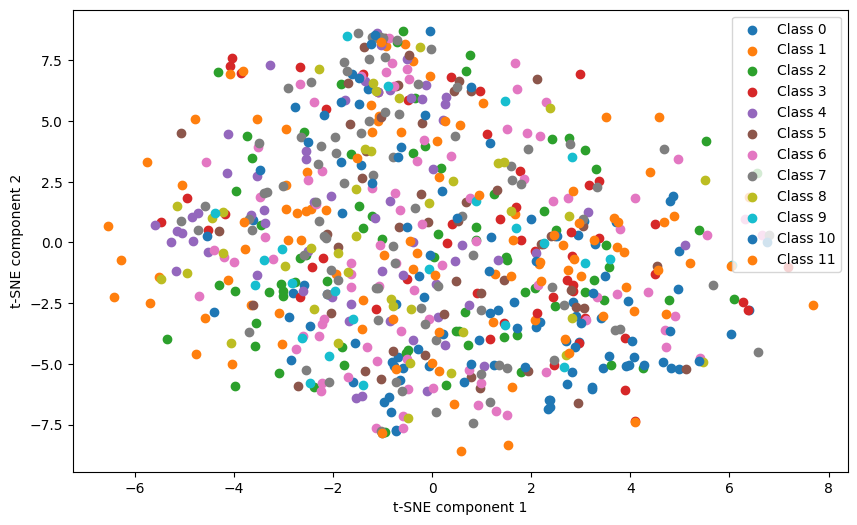

In [5]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from PIL import Image
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader
import csv
from torchvision.models import resnet18

class CustomDataset(torch.utils.data.Dataset):

    """
    Class which create a custom dataset
    """

    def __init__(self, image_paths, labels, transform=None):
        """
        Dataset creation

        Parameters:
        --------------------------------
        images_paths : str
            paths for each image
        labels : int
            label for each images,
        transform : torchvision.transforms.Compose
            transformation applied to the tensors
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


class ConvertToRGB(object):
    """
    Class which convert images in 3 canal (Red, Green, Blue)
    """

    def __call__(self, img):
        """
        Convert images in RGB

        Returns :
        -------------
        img : tensor
            images with 3 canals
        """
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

transformation = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
        transforms.Lambda(lambda x: torch.flatten(x))
    ]
)


with open(os.path.join('.', "test/image_list.txt"), "r") as f:
    lines = f.readlines()

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths_test = []
labels_test = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(" ")
    image_paths_test.append("test/" + line[0])
    labels_test.append(int(line[1]))
df_test = CustomDataset(image_paths_test, labels_test, transform=transformation)

import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE

# DataLoader pour le CustomDataset
dataloader = DataLoader(df_test, batch_size=1024, shuffle=True)

# Extraire les images et les étiquettes
for images, labels in dataloader:
    images_np = images.cpu().numpy()  # Les images sont déjà aplaties grâce à la transformation
    labels_np = labels.cpu().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(images_np)

# Visualisation
plt.figure(figsize=(10, 6))
for i in range(12):  # Supposant que les classes sont étiquetées de 0 à 11.
    mask = labels_np == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=f'Class {i}')
plt.legend()
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()


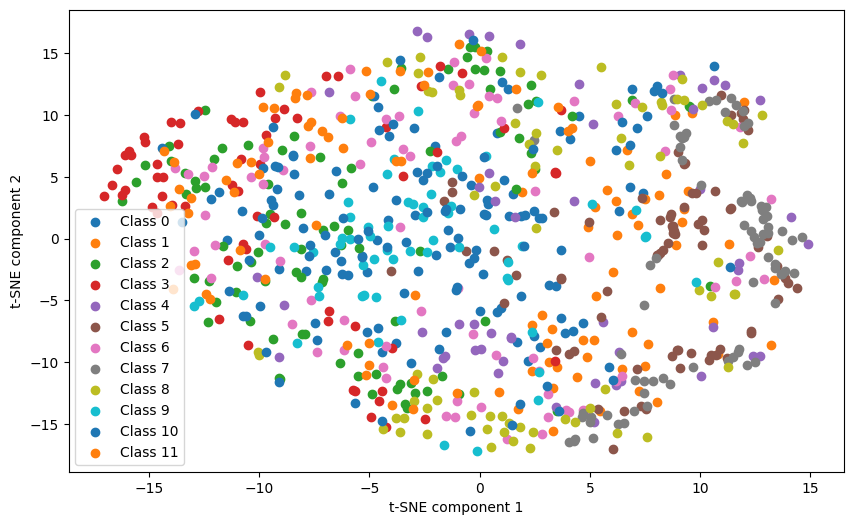

In [6]:
with open(os.path.join('.', "train/image_list.txt"), "r") as f:
    
    lines = f.readlines()  # [next(f) for _ in range(1000)]

    # Créer des listes pour stocker les chemins d'image et les étiquettes
    image_paths = []
    labels = []

    # Parcourir chaque ligne du fichier texte et extraire les informations
    for line in lines:
        line = line.strip().split(" ")
        image_paths.append("train/" + line[0])
        labels.append(int(line[1]))

    # Appliquer les transformations d'image si nécessaire
    transform_train = transforms.Compose(
        [
            ConvertToRGB(),
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.Lambda(lambda x: torch.flatten(x))
        ]
    )

df_train = CustomDataset(image_paths, labels, transform=transform_train)
dataloader = DataLoader(df_train, batch_size=1024, shuffle=True)

for images, labels in dataloader:
    images_np = images.cpu().numpy()  # Les images sont déjà aplaties grâce à la transformation
    labels_np = labels.cpu().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(images_np)

# Visualisation
plt.figure(figsize=(10, 6))
for i in range(12):  # Supposant que les classes sont étiquetées de 0 à 11.
    mask = labels_np == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=f'Class {i}')
plt.legend()
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

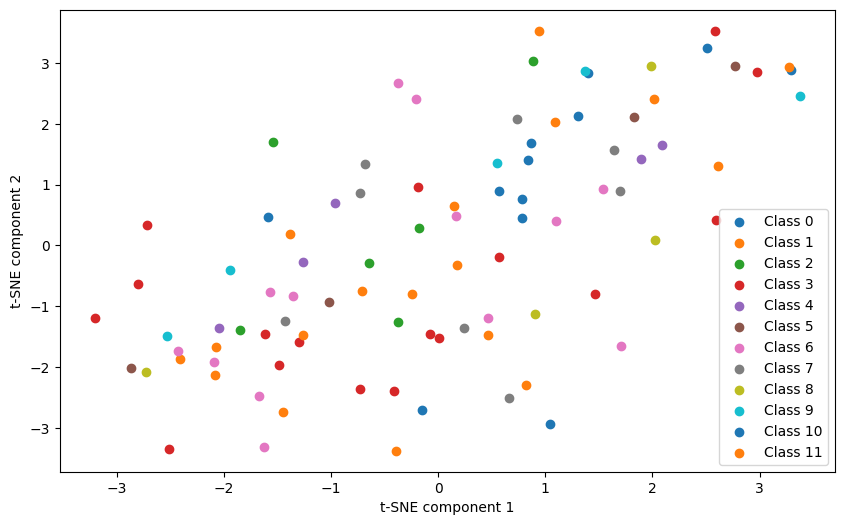

In [7]:
with open(os.path.join('.', "validation/image_list.txt"), "r") as f:
    lines = f.readlines()

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths_val = []
labels_val = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(" ")
    image_paths_val.append("validation/" + line[0])
    labels_val.append(int(line[1]))
df_val = CustomDataset(image_paths_val, labels_val, transform=transformation)

import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE

# DataLoader pour le CustomDataset
dataloader = DataLoader(df_val, batch_size=1024, shuffle=True)

# Extraire les images et les étiquettes
for images, labels in dataloader:
    images_np = images.cpu().numpy()  # Les images sont déjà aplaties grâce à la transformation
    labels_np = labels.cpu().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(images_np)

# Visualisation
plt.figure(figsize=(10, 6))
for i in range(12):  # Supposant que les classes sont étiquetées de 0 à 11.
    mask = labels_np == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=f'Class {i}')
plt.legend()
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

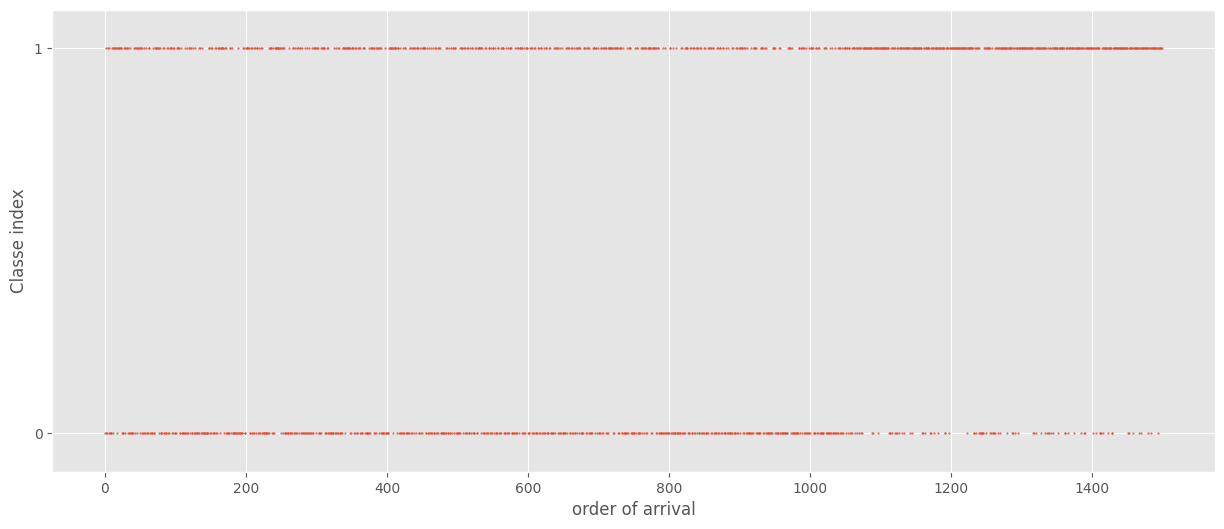

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os

df = pd.read_csv(os.path.join(os.path.join("result_online", "cnn_50_0.001_SGD_npb"), 'database.csv'), nrows=1)

def extract_tensor(tensor_str):
    content = tensor_str.split('[')[1].split(']')[0]
    return [float(x) for x in content.split(', ')]

tensor_strs = df.columns.tolist()
tensors = [extract_tensor(t) for t in tensor_strs]
class_indices = [tensor.index(max(tensor)) for tensor in tensors]

plt.style.use("ggplot")
plt.figure(figsize=(15,6))
plt.plot(class_indices, marker='o', markersize = 0.5 ,linestyle='')
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1])
plt.xlabel("order of arrival")
plt.ylabel("Classe index")
plt.show()



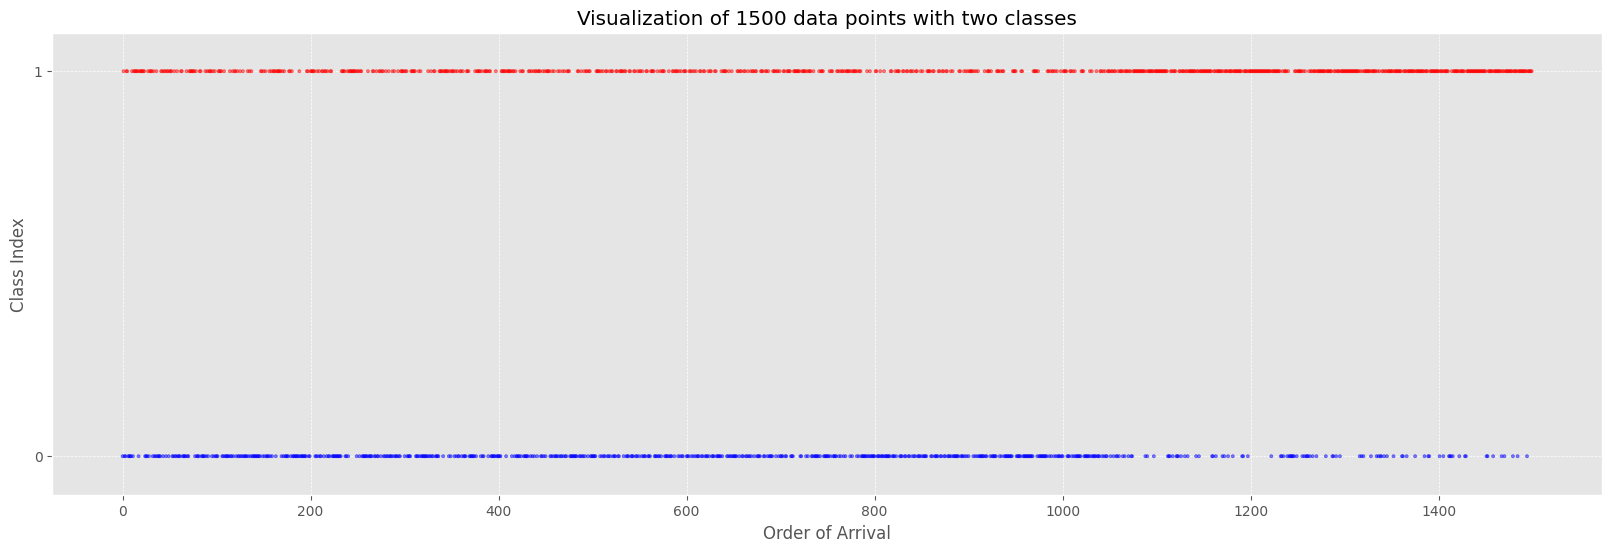

In [34]:
df = pd.read_csv(os.path.join(os.path.join("result_online", "cnn_50_0.001_SGD_npb"), 'database.csv'), nrows=1)

def extract_tensor(tensor_str):
    content = tensor_str.split('[')[1].split(']')[0]
    return [float(x) for x in content.split(', ')]

tensor_strs = df.columns.tolist()
tensors = [extract_tensor(t) for t in tensor_strs]
class_indices = [tensor.index(max(tensor)) for tensor in tensors]
colors = ['blue' if index == 0 else 'red' for index in class_indices]

plt.figure(figsize=(20,6))

# Scatter plot with semi-transparency
plt.scatter(range(1500), class_indices, color=colors, s=5, alpha=0.5)

plt.ylim(-0.1, 1.1)
plt.yticks([0, 1])
plt.xlabel("Order of Arrival")
plt.ylabel("Class Index")
plt.grid(True, which='both', markersize = 0.5, linestyle='--', linewidth=0.5)
plt.title("Visualization of 1500 data points with two classes")

plt.show()

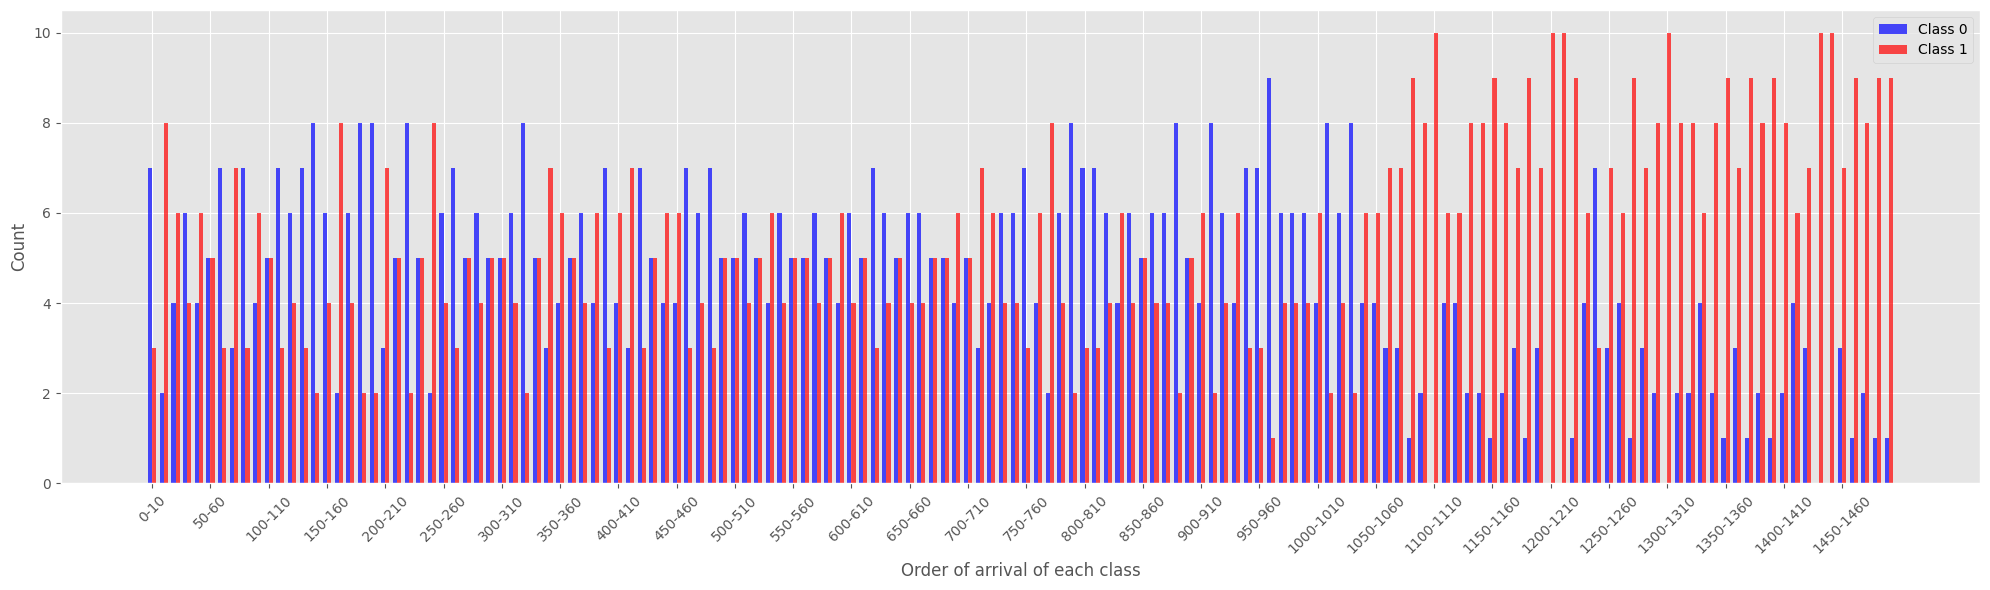

In [36]:
import numpy as np

df = pd.read_csv(os.path.join(os.path.join("result_online", "cnn_50_0.001_SGD_npb"), 'database.csv'), nrows=1)

def extract_tensor(tensor_str):
    content = tensor_str.split('[')[1].split(']')[0]
    return [float(x) for x in content.split(', ')]

tensor_strs = df.columns.tolist()
tensors = [extract_tensor(t) for t in tensor_strs]
class_indices = [tensor.index(max(tensor)) for tensor in tensors]

# Divide the data into blocks of 10
blocks = [class_indices[i:i+10] for i in range(0, len(class_indices), 10)]

# Count the occurrences of each class in each block
counts = [(block.count(0), block.count(1)) for block in blocks]

# Prepare data for plotting
class_0_counts = [count[0] for count in counts]
class_1_counts = [count[1] for count in counts]

# Plot
plt.figure(figsize=(20,6))

# Create a range for X axis locations
bar_locations = np.arange(len(counts))

# Width of a bar
bar_width = 0.35

# Plot bars for each class
plt.bar(bar_locations, class_0_counts, bar_width, color='blue', label='Class 0', alpha=0.7)
plt.bar(bar_locations + bar_width, class_1_counts, bar_width, color='red', label='Class 1', alpha=0.7)

# Setting the labels, title, and legend
plt.xlabel('Order of arrival of each class')
plt.ylabel('Count')

# Here's the modification: set x-ticks every 50 epochs (or every 5 blocks since each block is 10 data points)
plt.xticks(bar_locations[::5] + bar_width / 2, (str(i*10) + '-' + str((i+1)*10) for i in range(0, len(counts), 5)), rotation=45)

plt.legend()

# Display the plot
plt.tight_layout()
plt.show()



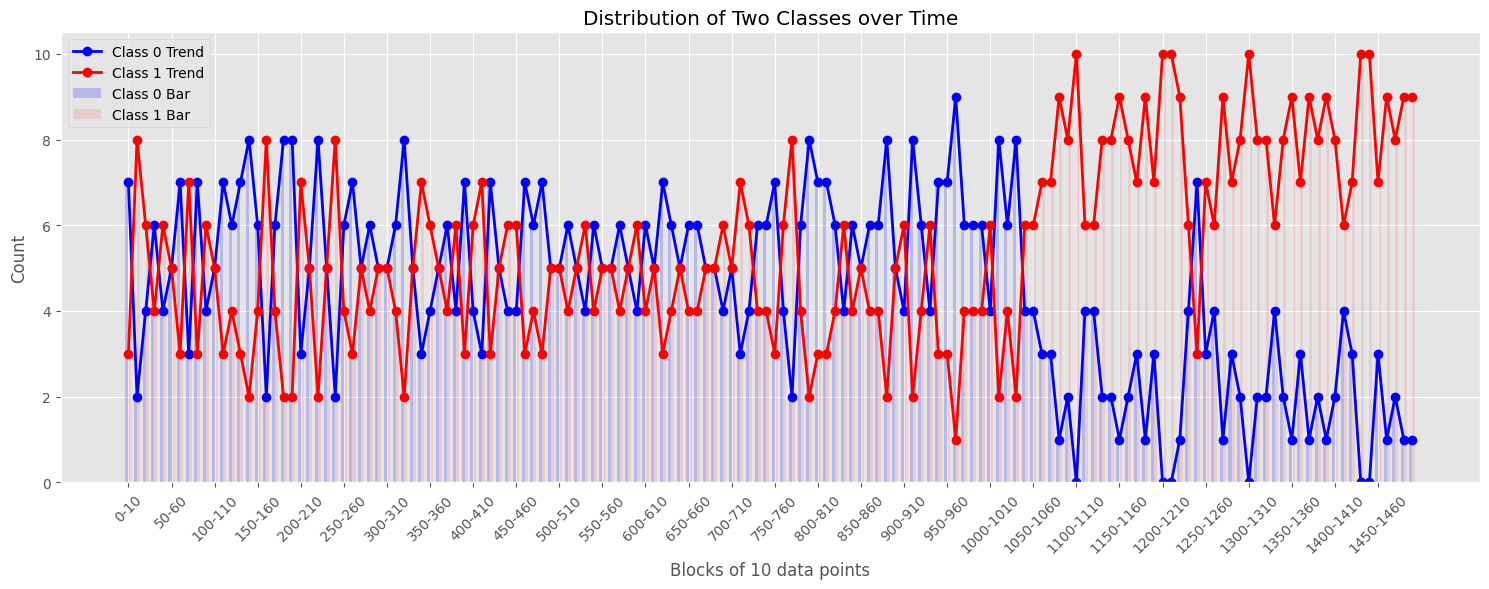

In [40]:
import numpy as np

df = pd.read_csv(os.path.join(os.path.join("result_online", "cnn_50_0.001_SGD_npb"), 'database.csv'), nrows=1)

def extract_tensor(tensor_str):
    content = tensor_str.split('[')[1].split(']')[0]
    return [float(x) for x in content.split(', ')]

tensor_strs = df.columns.tolist()
tensors = [extract_tensor(t) for t in tensor_strs]
class_indices = [tensor.index(max(tensor)) for tensor in tensors]

# Divide the data into blocks of 10
blocks = [class_indices[i:i+10] for i in range(0, len(class_indices), 10)]

# Count the occurrences of each class in each block
counts = [(block.count(0), block.count(1)) for block in blocks]

# Prepare data for plotting
class_0_counts = [count[0] for count in counts]
class_1_counts = [count[1] for count in counts]

# Plot
plt.figure(figsize=(15,6))

# Create a range for X axis locations
bar_locations = np.arange(len(counts))

# Width of a bar
bar_width = 0.35

# Plot bars for each class
plt.bar(bar_locations, class_0_counts, bar_width, color='blue', label='Class 0 Bar', alpha=0.2)
plt.bar(bar_locations + bar_width, class_1_counts, bar_width, color='red', label='Class 1 Bar', alpha=0.1)

# Plot trend lines for each class
plt.plot(bar_locations + bar_width / 2, class_0_counts, color='blue', marker='o', linestyle='-', linewidth=2, label='Class 0 Trend')
plt.plot(bar_locations + bar_width / 2, class_1_counts, color='red', marker='o', linestyle='-', linewidth=2, label='Class 1 Trend')

# Setting the labels, title, and legend
plt.xlabel('Blocks of 10 data points')
plt.ylabel('Count')
plt.title('Distribution of Two Classes over Time')

# Set x-ticks every 50 epochs (or every 5 blocks since each block is 10 data points)
plt.xticks(bar_locations[::5] + bar_width / 2, (str(i*10) + '-' + str((i+1)*10) for i in range(0, len(counts), 5)), rotation=45)

plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


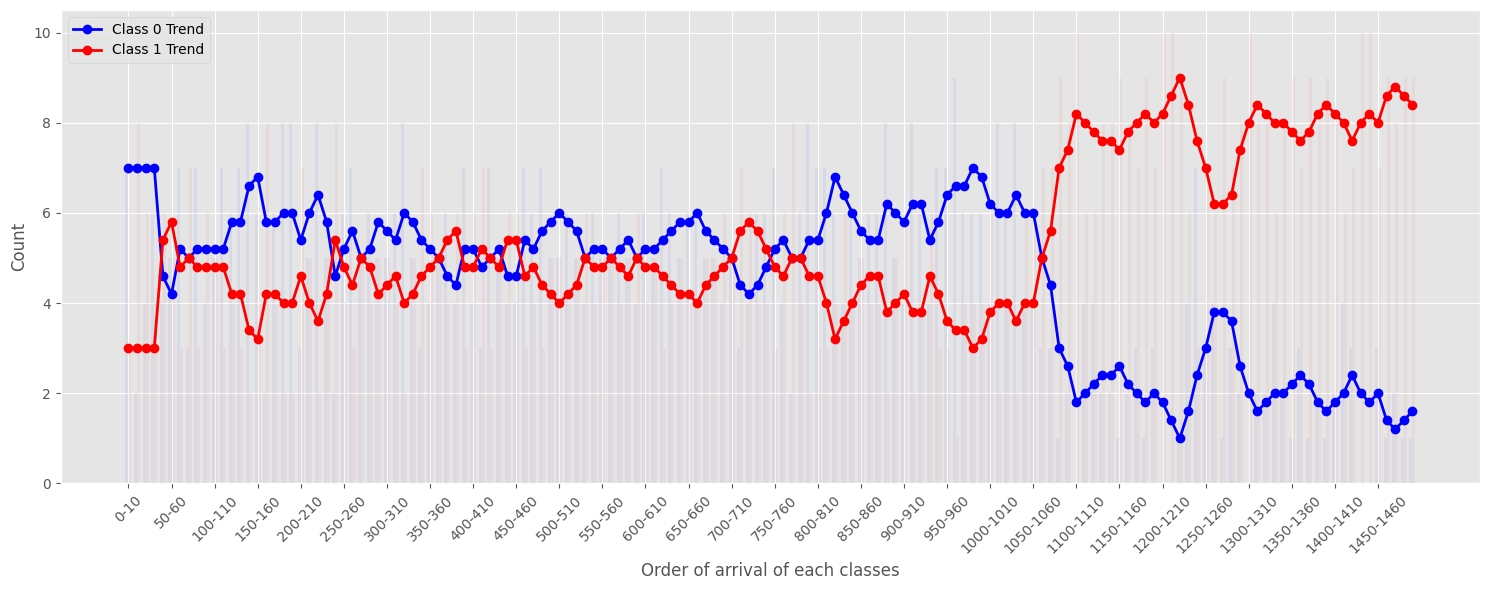

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(os.path.join(os.path.join("result_online", "cnn_50_0.001_SGD_npb"), 'database.csv'), nrows=1)

def extract_tensor(tensor_str):
    content = tensor_str.split('[')[1].split(']')[0]
    return [float(x) for x in content.split(', ')]

tensor_strs = df.columns.tolist()
tensors = [extract_tensor(t) for t in tensor_strs]
class_indices = [tensor.index(max(tensor)) for tensor in tensors]


# Divide the data into blocks of 10
blocks = [class_indices[i:i+10] for i in range(0, len(class_indices), 10)]

# Count the occurrences of each class in each block
counts = [(block.count(0), block.count(1)) for block in blocks]

# Prepare data for plotting
class_0_counts = [count[0] for count in counts]
class_1_counts = [count[1] for count in counts]

def moving_average(data, window_size):
    """Compute the moving average of a list."""
    cumsum = [0]
    moving_avgs = []

    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=window_size:
            moving_avg = (cumsum[i] - cumsum[i-window_size]) / window_size
            moving_avgs.append(moving_avg)

    # Pad the beginning with the first value to make it the same length as data
    return [data[0]] * (window_size - 1) + moving_avgs

# Apply moving average
window_size = 5
smoothed_class_0 = moving_average(class_0_counts, window_size)
smoothed_class_1 = moving_average(class_1_counts, window_size)

# Plotting
plt.figure(figsize=(15,6))

# Bar positions
bar_locations = np.arange(len(counts))
bar_width = 0.35

# Plot bars for each class with very low opacity
plt.bar(bar_locations, class_0_counts, bar_width, color='blue', alpha=0.05)
plt.bar(bar_locations + bar_width, class_1_counts, bar_width, color='red', alpha=0.05)

# Plot smoothed trend lines for each class
plt.plot(bar_locations + bar_width / 2, smoothed_class_0, color='blue', marker='o', linestyle='-', linewidth=2, label='Class 0 Trend')
plt.plot(bar_locations + bar_width / 2, smoothed_class_1, color='red', marker='o', linestyle='-', linewidth=2, label='Class 1 Trend')

# Labeling and display adjustments
plt.xlabel('Order of arrival of each classes')
plt.ylabel('Count')

# Set x-ticks every 50 epochs (or every 5 blocks since each block is 10 data points)
plt.xticks(bar_locations[::5] + bar_width / 2, (str(i*10) + '-' + str((i+1)*10) for i in range(0, len(counts), 5)), rotation=45)

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


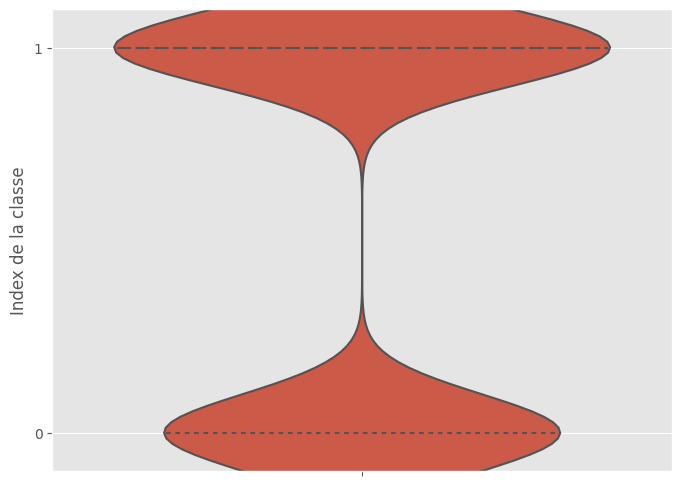

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

# Vos données et fonctions antérieures restent inchangées
df = pd.read_csv(os.path.join(os.path.join("result_online", "cnn_50_0.001_SGD_pb"), 'database.csv'))

def extract_tensor(tensor_str):
    content = tensor_str.split('[')[1].split(']')[0]
    return [float(x) for x in content.split(', ')]

tensor_strs = df.columns.tolist()
tensors = [extract_tensor(t) for t in tensor_strs]
class_indices = [tensor.index(max(tensor)) for tensor in tensors]

# Création d'un DataFrame pour le graphique en violon
violin_df = pd.DataFrame({
    "Ordre d'arrivée": range(len(class_indices)),
    "Index de la classe": class_indices
})


plt.figure(figsize=(8,6))
sns.violinplot(y=violin_df["Index de la classe"], inner="quartile", bw=0.2)
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1])
plt.ylabel("Index de la classe")
plt.show()


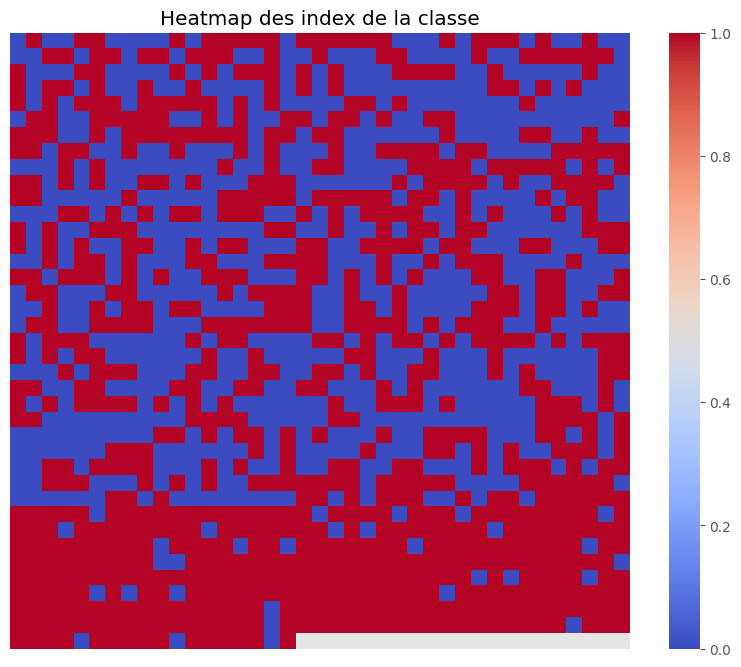

In [16]:
import numpy as np
import seaborn as sns

# Créer une matrice à partir de l'index de la classe (pour la démonstration)
# Dans cet exemple, je vais remodeler l'index de la classe en une matrice carrée.
# Cela est fait à titre démonstratif et peut ne pas avoir de sens réel pour vos données.

side_length = int(np.sqrt(len(class_indices)))
if side_length * side_length < len(class_indices):
    side_length += 1

# Remodeler et compléter les valeurs manquantes avec NaN
matrix = np.full((side_length, side_length), np.nan)
matrix.flat[:len(class_indices)] = class_indices

plt.figure(figsize=(10,8))
sns.heatmap(matrix, cmap="coolwarm", cbar=True, yticklabels=False, xticklabels=False)
plt.title("Heatmap des index de la classe")
plt.show()
